In [1]:
!pip install fsspec
!pip install gcsfs
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 140 kB 3.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 10.1 MB/s 
     |████████████████████████████████| 94 kB 1.8 MB/s 
     |████████████████████████████████| 144 kB 8.1 MB/s 
     |████████████████████████████████| 271 kB 41.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 7.1 MB/s 
     |████████████████████████████████| 6.6 MB 24.1 MB/s 
     |████████████████████████████████| 101 kB 5.0 MB/s 
     |████████████████████████████████| 596 kB 36.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
from google.colab import drive
drive.mount('/content/drive')
!ln -s "/content/drive/My Drive/Colab Notebooks/tfm"
import sys
sys.path.append('tfm/checkpoints/')
sys.path.append('tfm/outputs/')

Mounted at /content/drive


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tqdm.auto import tqdm
from transformers import (
    AutoTokenizer,
    TFBertForSequenceClassification,
)

In [4]:
filepath = "../../data/outputs/dataset_2021_paragraph"
filepath = "tfm/outputs/dataset_2021_paragraph" # Filepath COLAB
filepath = "https://storage.googleapis.com/tfm_aideas_datasets/dataset_2021_paragraph" # Filepath GCloud

In [5]:
df_total_labels = pd.read_csv(f"{filepath}_annotated.csv", sep=";", parse_dates=["date"])

In [6]:
no_doubts_labels = df_total_labels.topic_tag_news[df_total_labels.topic_tag_news < 15].unique()
topic_label = df_total_labels.topic_tag_news.isin(no_doubts_labels)
dataset_labels = df_total_labels[topic_label]
dataset_unlabelled = df_total_labels[~topic_label]

In [7]:
# Para no entrenar varias veces con los mismos párrafos debido a que hayan sido asignados
# a diferentes tickers
dataset_labels.drop_duplicates(subset=["body"], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [10]:
dataset_labels.topic_tag_news.value_counts()/sum(dataset_labels.topic_tag_news.value_counts())

11.0    0.274167
7.0     0.248498
10.0    0.104861
5.0     0.097761
12.0    0.058984
13.0    0.054069
6.0     0.045877
8.0     0.039323
4.0     0.031677
9.0     0.022938
3.0     0.015838
1.0     0.003823
14.0    0.002185
Name: topic_tag_news, dtype: float64

In [11]:
lb = LabelEncoder()
label = lb.fit_transform(dataset_labels.topic_tag_news)

A continuación se reentrena únicamente la última capa del modelo BETO para esta tarea de clasificación.

In [12]:
N_LABELS = len(np.unique(dataset_labels.topic_tag_news))

In [13]:
checkpoint = "dccuchile/bert-base-spanish-wwm-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/310 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/650 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/242k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/475k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134 [00:00<?, ?B/s]

In [14]:
model = TFBertForSequenceClassification.from_pretrained(checkpoint, num_labels=N_LABELS)

Downloading:   0%|          | 0.00/512M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
model.layers[0].trainable=False

In [16]:
model.compile(
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
optimizer=Adam(learning_rate=0.0001),
metrics=['accuracy']
)

In [17]:
x_train, x_test, y_train, y_test = train_test_split(dataset_labels.body_no_entities, label, test_size=0.2, random_state=42)

In [18]:
x_train = tokenizer(x_train.tolist(), padding="max_length", truncation=True, return_tensors="tf")

In [19]:
x_test = tokenizer(x_test.tolist(), padding="max_length", truncation=True, return_tensors="tf")

In [20]:
N_EPOCAS = 150

In [21]:
# filepath_checkpoint = './checkpoints/topic_tag_news/checkpoint'
filepath_checkpoint = 'tfm/checkpoints/topic_tag_news/checkpoint' # Filepath COLAB

model_checkpoint_callback = ModelCheckpoint(
    filepath=filepath_checkpoint,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

early_stopping = EarlyStopping(monitor='val_loss', patience=15, mode='min')

hist = model.fit(
    dict(x_train),
    y_train,
    batch_size=128,
    epochs=N_EPOCAS,
    validation_split=0.1,
    callbacks=[model_checkpoint_callback, early_stopping]
    )

Epoch 1/150
11/11 [==============================] - 63s 4s/step - loss: 2.5568 - accuracy: 0.1124 - val_loss: 2.4746 - val_accuracy: 0.2313
Epoch 2/150
11/11 [==============================] - 39s 4s/step - loss: 2.4490 - accuracy: 0.2035 - val_loss: 2.3549 - val_accuracy: 0.2925
Epoch 3/150
11/11 [==============================] - 39s 4s/step - loss: 2.3578 - accuracy: 0.2331 - val_loss: 2.2530 - val_accuracy: 0.3333
Epoch 4/150
11/11 [==============================] - 41s 4s/step - loss: 2.2793 - accuracy: 0.2475 - val_loss: 2.1664 - val_accuracy: 0.3469
Epoch 5/150
11/11 [==============================] - 40s 4s/step - loss: 2.2190 - accuracy: 0.2612 - val_loss: 2.0964 - val_accuracy: 0.3673
Epoch 6/150
11/11 [==============================] - 39s 4s/step - loss: 2.1649 - accuracy: 0.2749 - val_loss: 2.0400 - val_accuracy: 0.3878
Epoch 7/150
11/11 [==============================] - 37s 3s/step - loss: 2.1302 - accuracy: 0.2908 - val_loss: 1.9922 - val_accuracy: 0.3810
Epoch 8/150
1

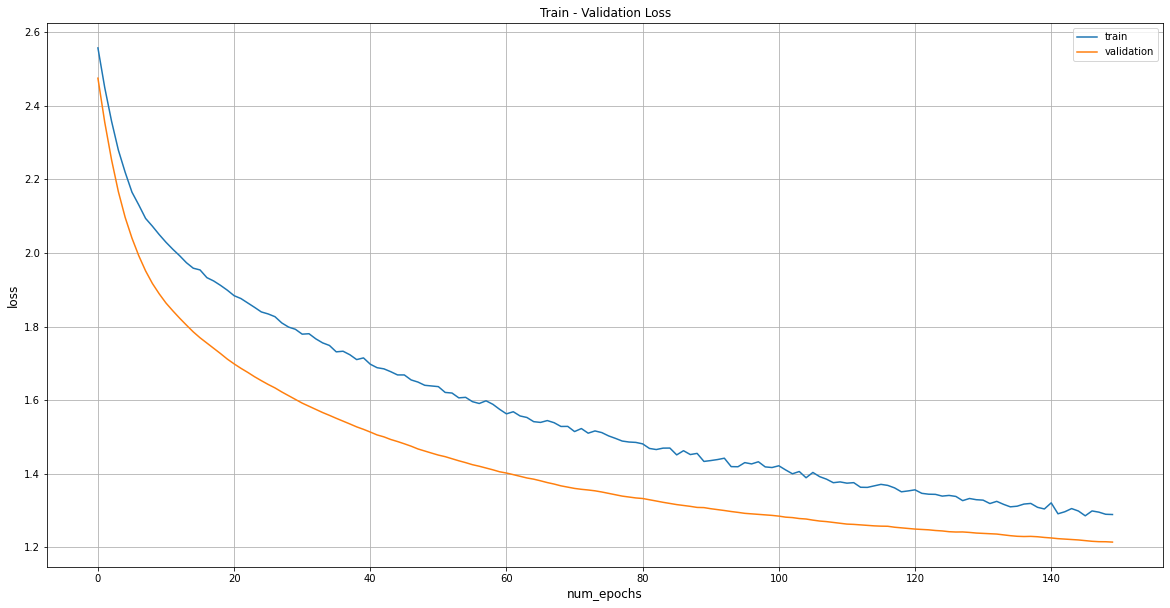

In [22]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Loss")
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')
plt.grid()
plt.show()

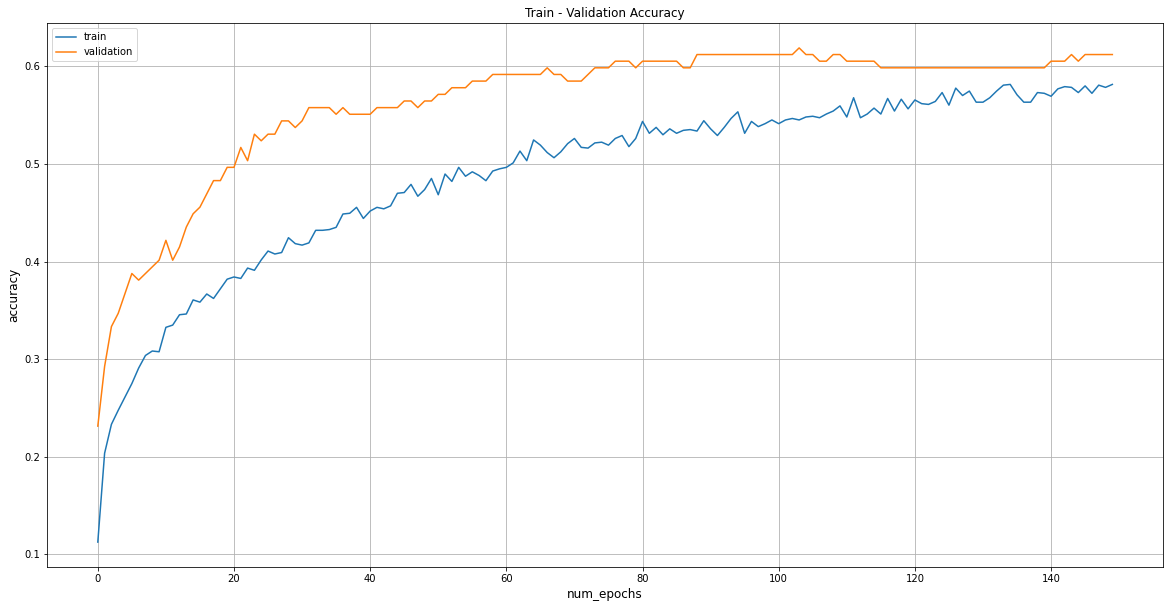

In [23]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Accuracy")
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')
plt.grid()
plt.show()

In [24]:
model.load_weights(filepath_checkpoint)
model.evaluate(x_test.data, y_test)

12/12 [==============================] - 9s 713ms/step - loss: 1.4961 - accuracy: 0.4823


[1.4961214065551758, 0.48228883743286133]

In [25]:
# Comparativa con una predicción por clase mayoritaria de train:

pd.Series(y_train).value_counts()/sum(pd.Series(y_train).value_counts())

9     0.278005
5     0.246585
8     0.107923
3     0.096995
10    0.057377
11    0.051913
4     0.047131
6     0.037568
2     0.031421
7     0.020492
1     0.019126
0     0.004098
12    0.001366
dtype: float64

In [26]:
y_pred = model.predict(x_test.data)

In [27]:
y_pred = y_pred.logits.argmax(axis=1)

In [28]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.71      0.42      0.53        12
           3       0.40      0.46      0.43        37
           4       0.50      0.20      0.29        15
           5       0.49      0.62      0.54        94
           6       0.00      0.00      0.00        17
           7       0.00      0.00      0.00        12
           8       0.66      0.74      0.69        34
           9       0.46      0.71      0.56        95
          10       0.12      0.04      0.06        24
          11       0.50      0.04      0.08        23
          12       0.00      0.00      0.00         2

    accuracy                           0.48       367
   macro avg       0.30      0.25      0.24       367
weighted avg       0.43      0.48      0.43       367



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


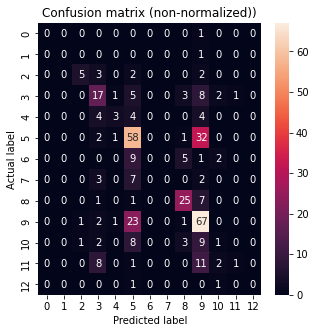

In [29]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix (non-normalized))")
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")


plot_cm(y_test, y_pred)

In [ ]:
def func_apply(row):
    if (not type(row.body_no_entities)==str):    
        row.body_no_entities = str(row.body_no_entities)
    x = tokenizer(row.body_no_entities, padding="max_length", truncation=True, return_tensors="tf")
    y_pred = model.predict(x.data)
    row['topic_tag_news'] = int(lb.inverse_transform(y_pred.logits.argmax(axis=1))[0])
    row['topic_tag_news_proba'] = tf.nn.softmax(y_pred.logits).numpy().max(axis=1)[0]
    return row

In [ ]:
tqdm.pandas()
df_total_labels["topic_tag_news_proba"] = np.NaN
df_total_labels.loc[topic_label, "topic_tag_news_proba"] = 1.
df_total_labels.loc[~topic_label] = df_total_labels.loc[~topic_label].progress_apply(lambda row : func_apply(row), axis=1)

  0%|          | 0/10831 [00:00<?, ?it/s]

In [ ]:
df_total_labels.to_csv(f'{filepath}_predict_topic_tag_news.csv', sep=";")

# Transfer Learning con BETO con KFold

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 1...
Epoch 1/60
47/47 [==============================] - 71s 1s/step - loss: 2.4259 - accuracy: 0.2004 - val_loss: 2.2444 - val_accuracy: 0.2848
Epoch 2/60
47/47 [==============================] - 43s 924ms/step - loss: 2.1607 - accuracy: 0.3070 - val_loss: 2.0755 - val_accuracy: 0.2788
Epoch 3/60
47/47 [==============================] - 45s 959ms/step - loss: 2.0458 - accuracy: 0.3435 - val_loss: 1.9974 - val_accuracy: 0.2909
Epoch 4/60
47/47 [==============================] - 46s 974ms/step - loss: 1.9852 - accuracy: 0.3603 - val_loss: 1.9607 - val_accuracy: 0.3152
Epoch 5/60
47/47 [==============================] - 45s 959ms/step - loss: 1.9362 - accuracy: 0.3711 - val_loss: 1.9292 - val_accuracy: 0.3273
Epoch 6/60
47/47 [==============================] - 45s 961ms/step - loss: 1.9022 - accuracy: 0.3947 - val_loss: 1.9068 - val_accuracy: 0.3333
Epoch 7/60
47/47 [==============================] - 45s 961ms/step - loss: 1.8694 - accuracy: 0.3893 - val_loss: 1.8798 -

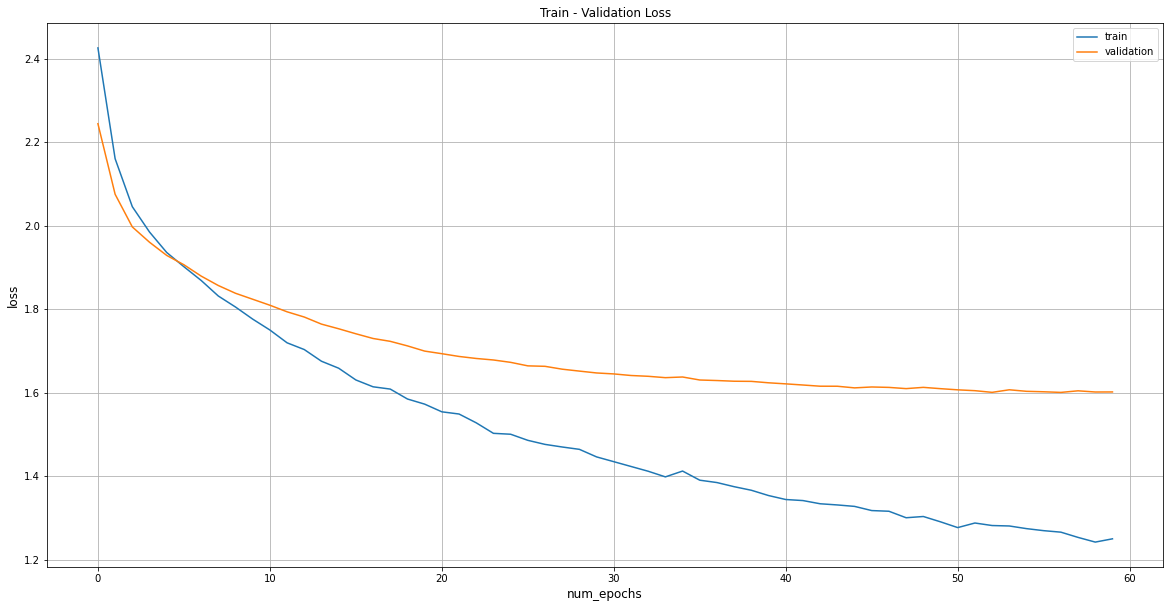

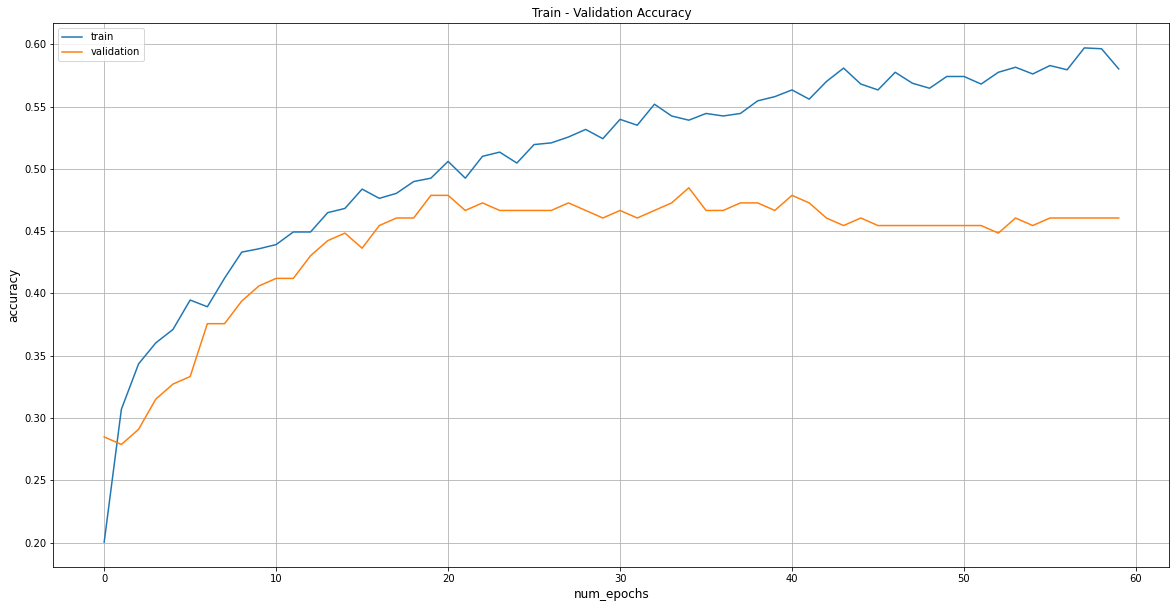

6/6 [==============================] - 4s 720ms/step - loss: 1.5783 - accuracy: 0.5000
Accuracy: 0.5


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 2...
Epoch 1/60
47/47 [==============================] - 63s 1s/step - loss: 2.3715 - accuracy: 0.2266 - val_loss: 2.2274 - val_accuracy: 0.2485
Epoch 2/60
47/47 [==============================] - 45s 959ms/step - loss: 2.1587 - accuracy: 0.3028 - val_loss: 2.1089 - val_accuracy: 0.2606
Epoch 3/60
47/47 [==============================] - 45s 961ms/step - loss: 2.0588 - accuracy: 0.3270 - val_loss: 2.0547 - val_accuracy: 0.2909
Epoch 4/60
47/47 [==============================] - 45s 960ms/step - loss: 2.0021 - accuracy: 0.3587 - val_loss: 2.0162 - val_accuracy: 0.2970
Epoch 5/60
47/47 [==============================] - 45s 960ms/step - loss: 1.9555 - accuracy: 0.3769 - val_loss: 1.9796 - val_accuracy: 0.3091
Epoch 6/60
47/47 [==============================] - 43s 926ms/step - loss: 1.9170 - accuracy: 0.3931 - val_loss: 1.9620 - val_accuracy: 0.3091
Epoch 7/60
47/47 [==============================] - 46s 974ms/step - loss: 1.8842 - accuracy: 0.3951 - val_loss: 1.9302 -

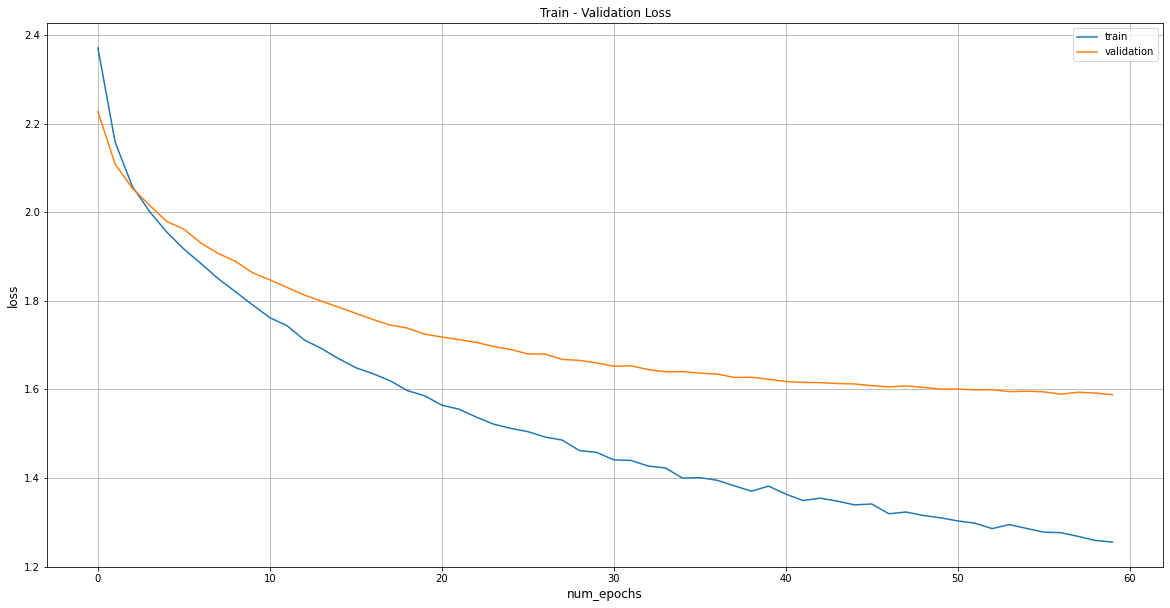

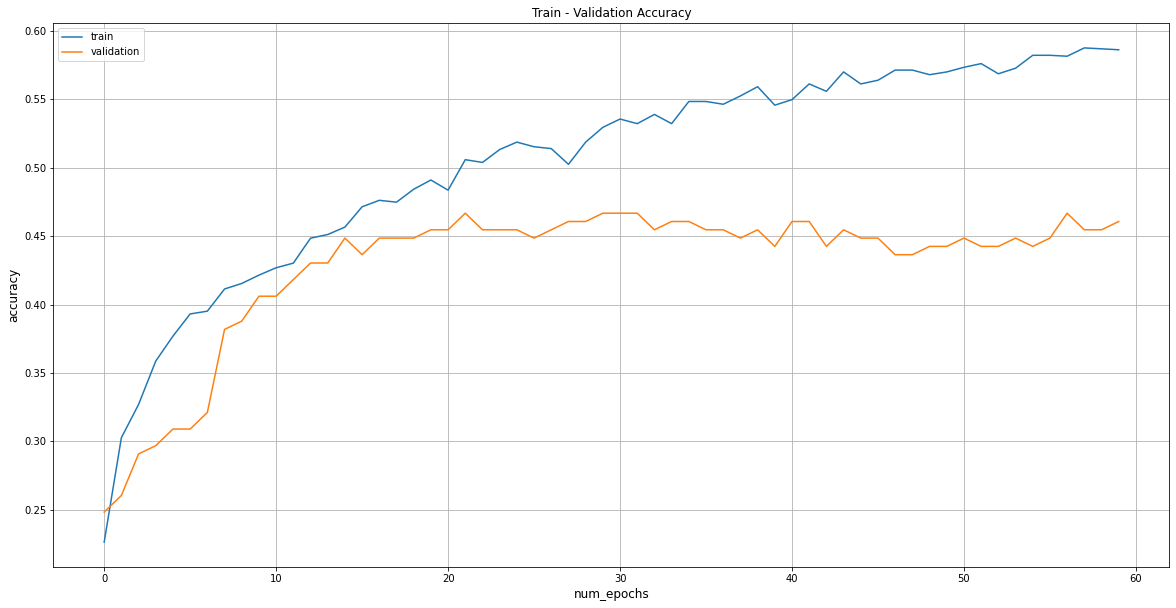

6/6 [==============================] - 4s 712ms/step - loss: 1.5603 - accuracy: 0.4699
Accuracy: 0.46994534134864807


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 3...
Epoch 1/60
47/47 [==============================] - 64s 1s/step - loss: 2.4102 - accuracy: 0.2192 - val_loss: 2.2386 - val_accuracy: 0.2727
Epoch 2/60
47/47 [==============================] - 46s 976ms/step - loss: 2.1559 - accuracy: 0.3183 - val_loss: 2.0966 - val_accuracy: 0.2848
Epoch 3/60
47/47 [==============================] - 45s 965ms/step - loss: 2.0448 - accuracy: 0.3554 - val_loss: 2.0347 - val_accuracy: 0.3091
Epoch 4/60
47/47 [==============================] - 45s 961ms/step - loss: 1.9821 - accuracy: 0.3803 - val_loss: 1.9997 - val_accuracy: 0.3273
Epoch 5/60
47/47 [==============================] - 43s 926ms/step - loss: 1.9444 - accuracy: 0.3871 - val_loss: 1.9740 - val_accuracy: 0.3273
Epoch 6/60
47/47 [==============================] - 45s 960ms/step - loss: 1.9062 - accuracy: 0.3898 - val_loss: 1.9504 - val_accuracy: 0.3515
Epoch 7/60
47/47 [==============================] - 46s 977ms/step - loss: 1.8685 - accuracy: 0.3972 - val_loss: 1.9314 -

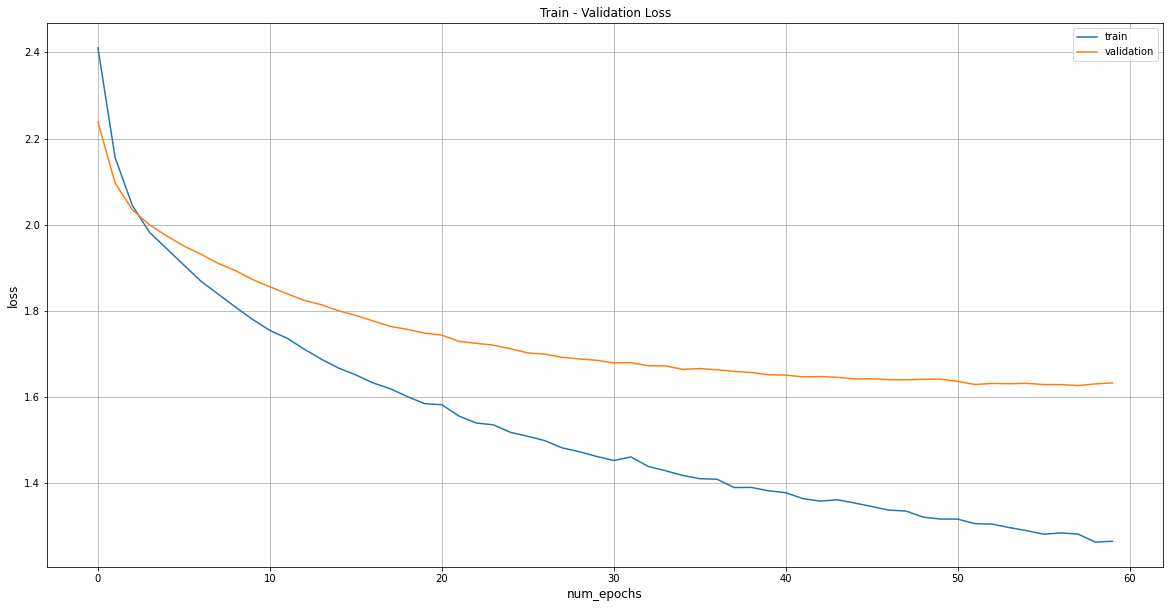

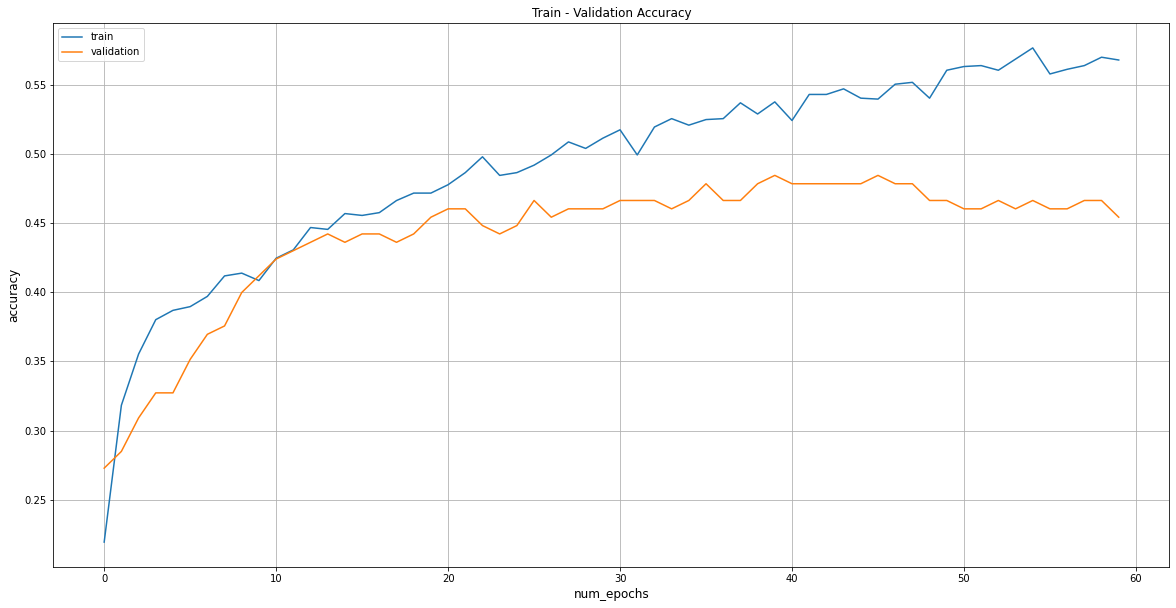

6/6 [==============================] - 4s 709ms/step - loss: 1.3889 - accuracy: 0.5464
Accuracy: 0.5464481115341187


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 4...
Epoch 1/60
47/47 [==============================] - 63s 1s/step - loss: 2.3898 - accuracy: 0.2138 - val_loss: 2.2506 - val_accuracy: 0.2970
Epoch 2/60
47/47 [==============================] - 45s 964ms/step - loss: 2.1561 - accuracy: 0.3034 - val_loss: 2.1223 - val_accuracy: 0.3091
Epoch 3/60
47/47 [==============================] - 45s 963ms/step - loss: 2.0405 - accuracy: 0.3358 - val_loss: 2.0685 - val_accuracy: 0.3152
Epoch 4/60
47/47 [==============================] - 44s 928ms/step - loss: 1.9807 - accuracy: 0.3608 - val_loss: 2.0272 - val_accuracy: 0.3152
Epoch 5/60
47/47 [==============================] - 46s 975ms/step - loss: 1.9441 - accuracy: 0.3675 - val_loss: 2.0010 - val_accuracy: 0.3394
Epoch 6/60
47/47 [==============================] - 45s 962ms/step - loss: 1.9011 - accuracy: 0.3702 - val_loss: 1.9750 - val_accuracy: 0.3455
Epoch 7/60
47/47 [==============================] - 46s 974ms/step - loss: 1.8682 - accuracy: 0.3776 - val_loss: 1.9495 -

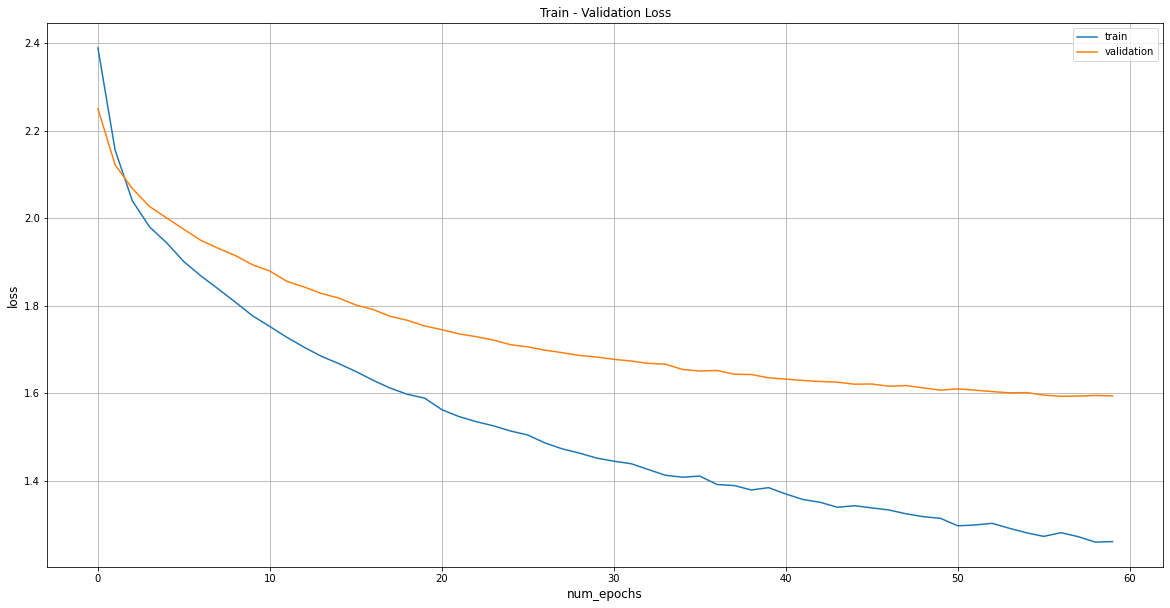

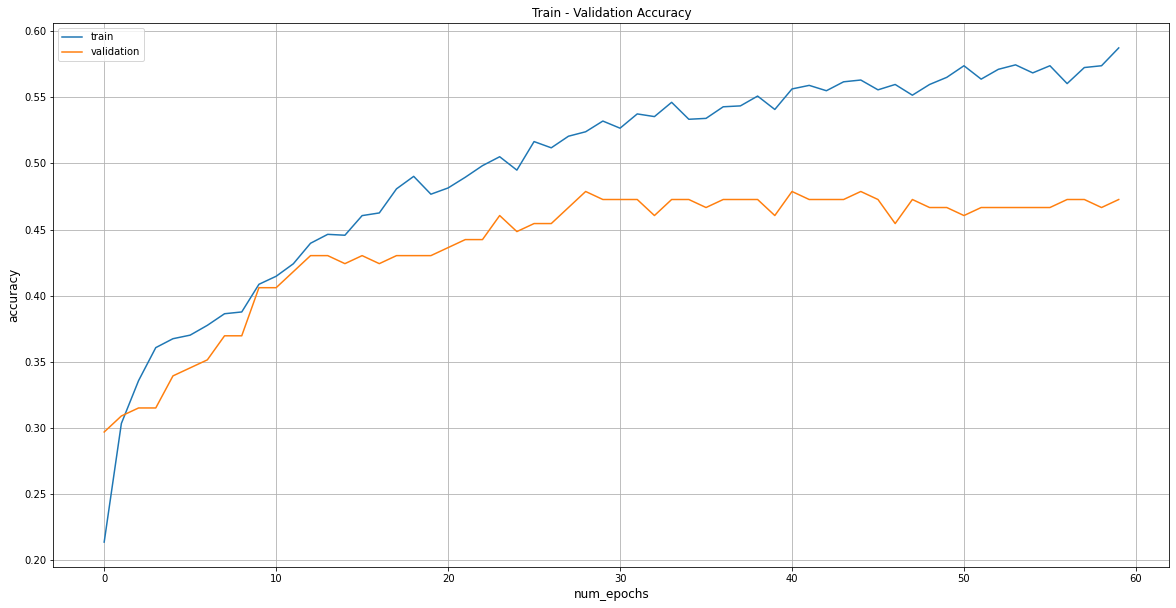

6/6 [==============================] - 4s 713ms/step - loss: 1.4935 - accuracy: 0.5027
Accuracy: 0.5027322173118591


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 5...
Epoch 1/60
47/47 [==============================] - 64s 1s/step - loss: 2.3520 - accuracy: 0.2353 - val_loss: 2.2149 - val_accuracy: 0.1818
Epoch 2/60
47/47 [==============================] - 45s 965ms/step - loss: 2.1228 - accuracy: 0.3034 - val_loss: 2.0892 - val_accuracy: 0.2242
Epoch 3/60
47/47 [==============================] - 45s 966ms/step - loss: 2.0258 - accuracy: 0.3358 - val_loss: 2.0378 - val_accuracy: 0.2424
Epoch 4/60
47/47 [==============================] - 45s 965ms/step - loss: 1.9723 - accuracy: 0.3655 - val_loss: 2.0045 - val_accuracy: 0.2545
Epoch 5/60
47/47 [==============================] - 43s 926ms/step - loss: 1.9322 - accuracy: 0.3709 - val_loss: 1.9812 - val_accuracy: 0.2303
Epoch 6/60
47/47 [==============================] - 46s 975ms/step - loss: 1.8953 - accuracy: 0.3763 - val_loss: 1.9542 - val_accuracy: 0.2606
Epoch 7/60
47/47 [==============================] - 45s 962ms/step - loss: 1.8654 - accuracy: 0.3999 - val_loss: 1.9311 -

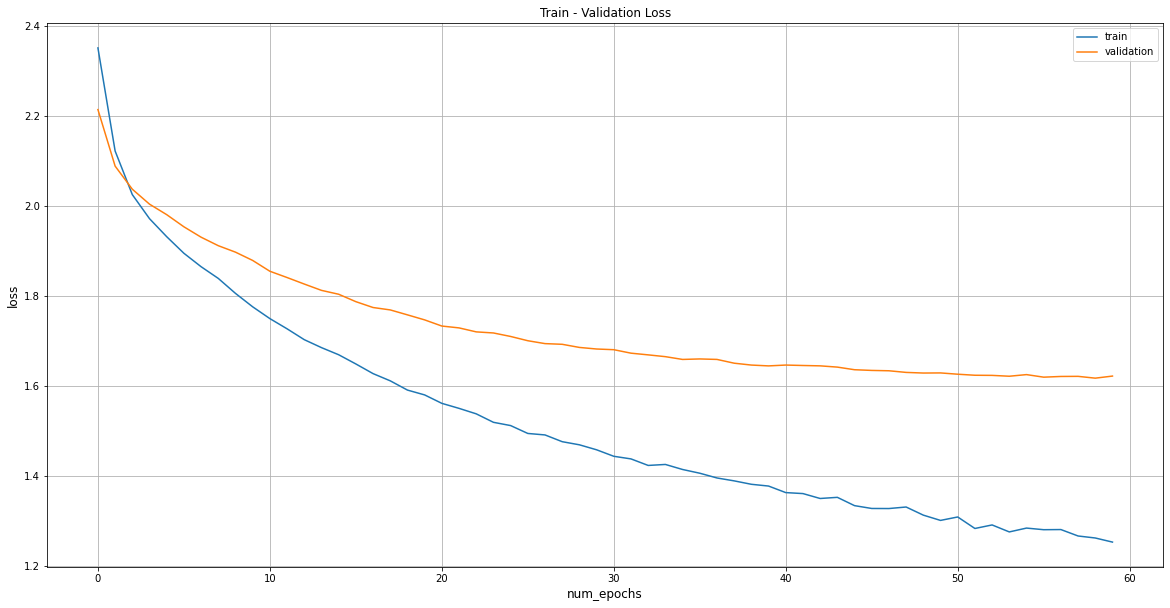

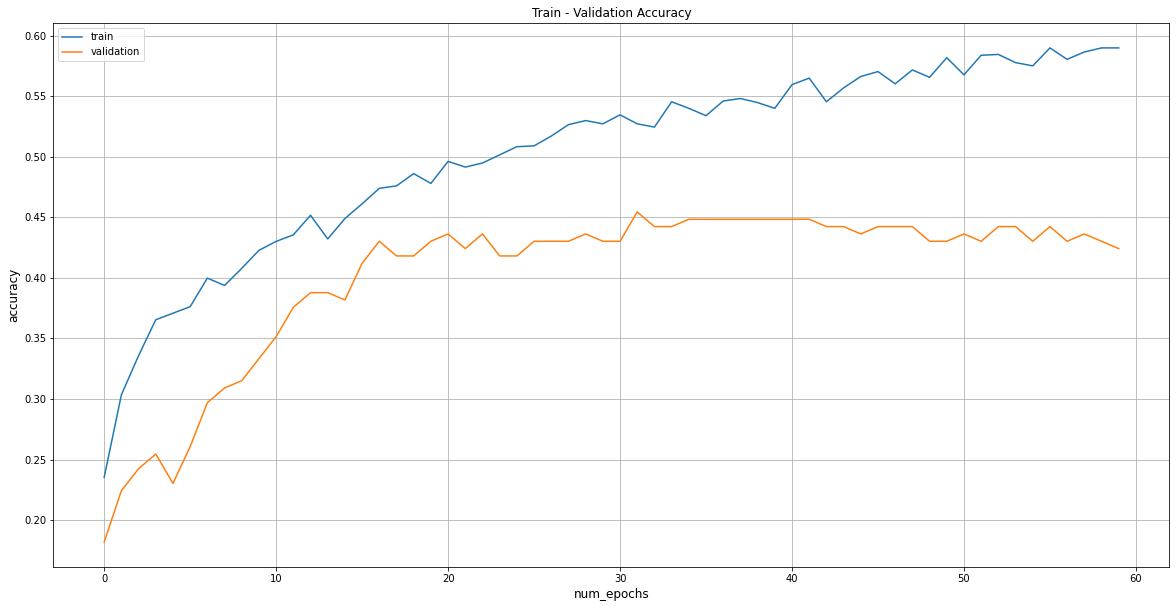

6/6 [==============================] - 4s 709ms/step - loss: 1.4439 - accuracy: 0.5519
Accuracy: 0.5519125461578369


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 6...
Epoch 1/60
47/47 [==============================] - 64s 1s/step - loss: 2.3979 - accuracy: 0.2171 - val_loss: 2.2215 - val_accuracy: 0.2303
Epoch 2/60
47/47 [==============================] - 45s 964ms/step - loss: 2.1711 - accuracy: 0.2953 - val_loss: 2.0683 - val_accuracy: 0.2545
Epoch 3/60
47/47 [==============================] - 46s 980ms/step - loss: 2.0635 - accuracy: 0.3243 - val_loss: 2.0016 - val_accuracy: 0.2727
Epoch 4/60
47/47 [==============================] - 45s 963ms/step - loss: 2.0012 - accuracy: 0.3621 - val_loss: 1.9588 - val_accuracy: 0.2848
Epoch 5/60
47/47 [==============================] - 46s 974ms/step - loss: 1.9567 - accuracy: 0.3736 - val_loss: 1.9274 - val_accuracy: 0.2970
Epoch 6/60
47/47 [==============================] - 45s 960ms/step - loss: 1.9251 - accuracy: 0.3810 - val_loss: 1.9014 - val_accuracy: 0.3152
Epoch 7/60
47/47 [==============================] - 46s 974ms/step - loss: 1.8863 - accuracy: 0.3958 - val_loss: 1.8765 -

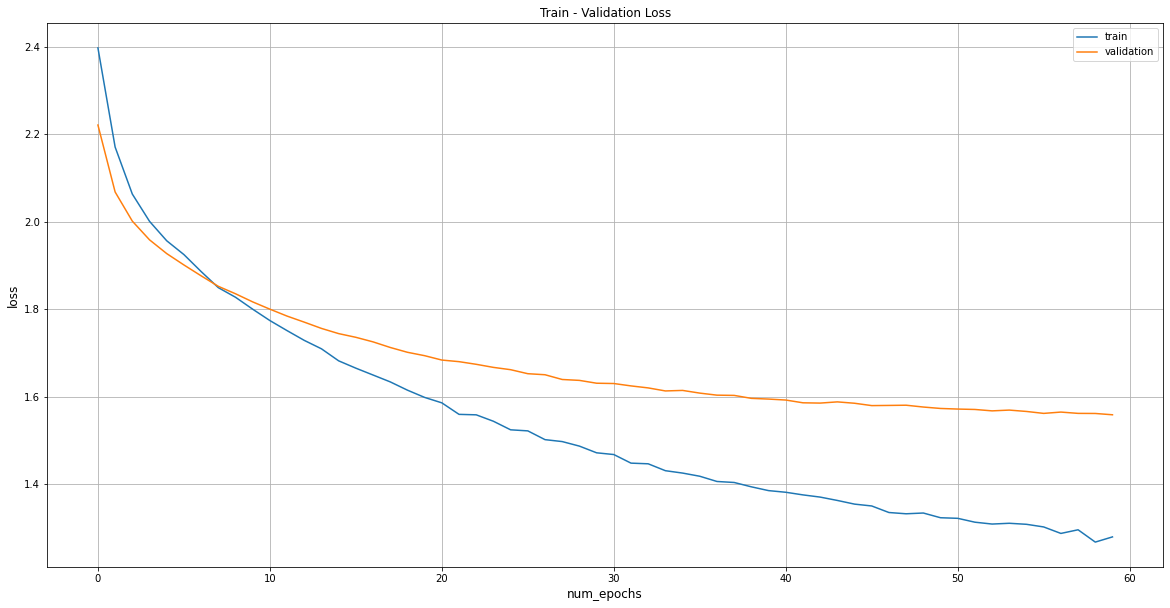

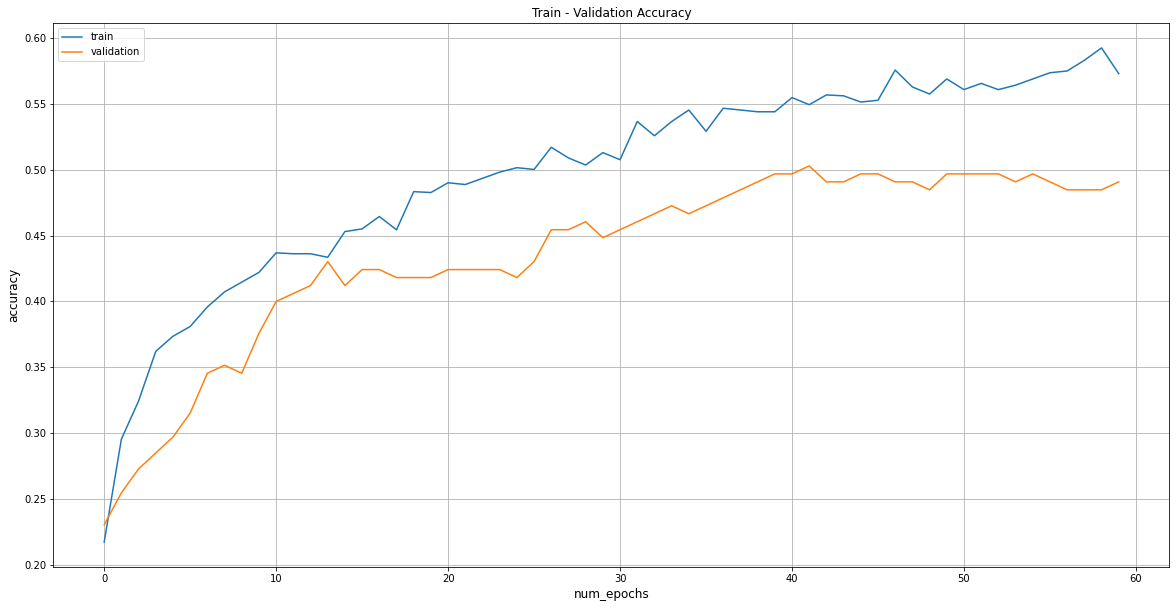

6/6 [==============================] - 4s 706ms/step - loss: 1.3632 - accuracy: 0.5628
Accuracy: 0.562841534614563


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 7...
Epoch 1/60
47/47 [==============================] - 64s 1s/step - loss: 2.4444 - accuracy: 0.1787 - val_loss: 2.2631 - val_accuracy: 0.2788
Epoch 2/60
47/47 [==============================] - 43s 927ms/step - loss: 2.1802 - accuracy: 0.2839 - val_loss: 2.1051 - val_accuracy: 0.2485
Epoch 3/60
47/47 [==============================] - 43s 926ms/step - loss: 2.0652 - accuracy: 0.3142 - val_loss: 2.0466 - val_accuracy: 0.2424
Epoch 4/60
47/47 [==============================] - 43s 925ms/step - loss: 2.0033 - accuracy: 0.3506 - val_loss: 2.0094 - val_accuracy: 0.2364
Epoch 5/60
47/47 [==============================] - 44s 927ms/step - loss: 1.9564 - accuracy: 0.3695 - val_loss: 1.9814 - val_accuracy: 0.2667
Epoch 6/60
47/47 [==============================] - 43s 925ms/step - loss: 1.9169 - accuracy: 0.3999 - val_loss: 1.9502 - val_accuracy: 0.2667
Epoch 7/60
47/47 [==============================] - 45s 963ms/step - loss: 1.8793 - accuracy: 0.4053 - val_loss: 1.9287 -

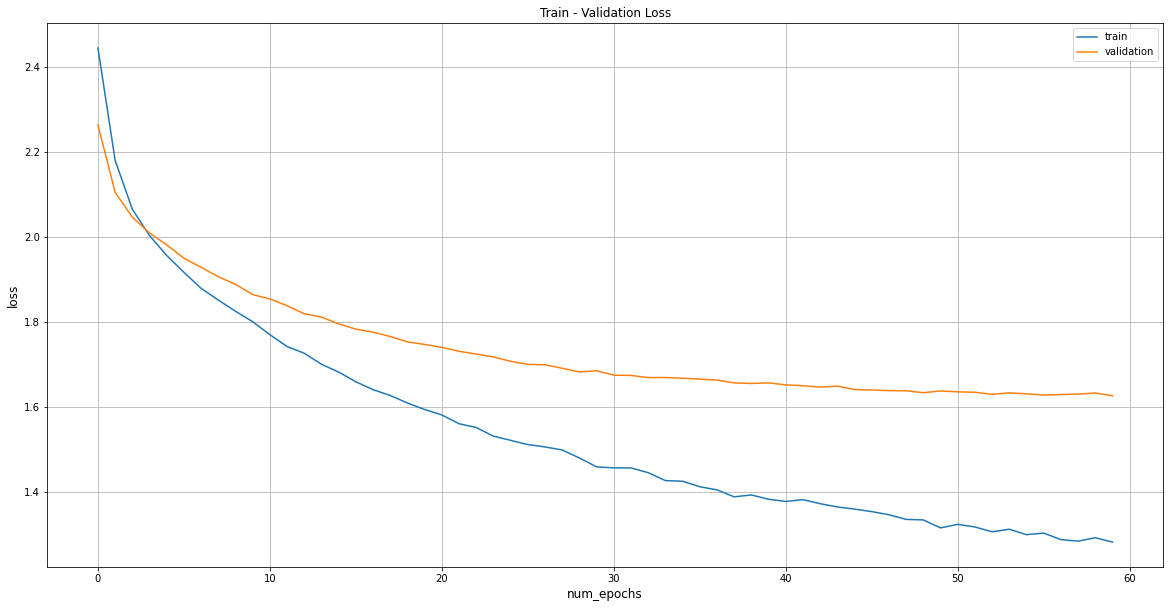

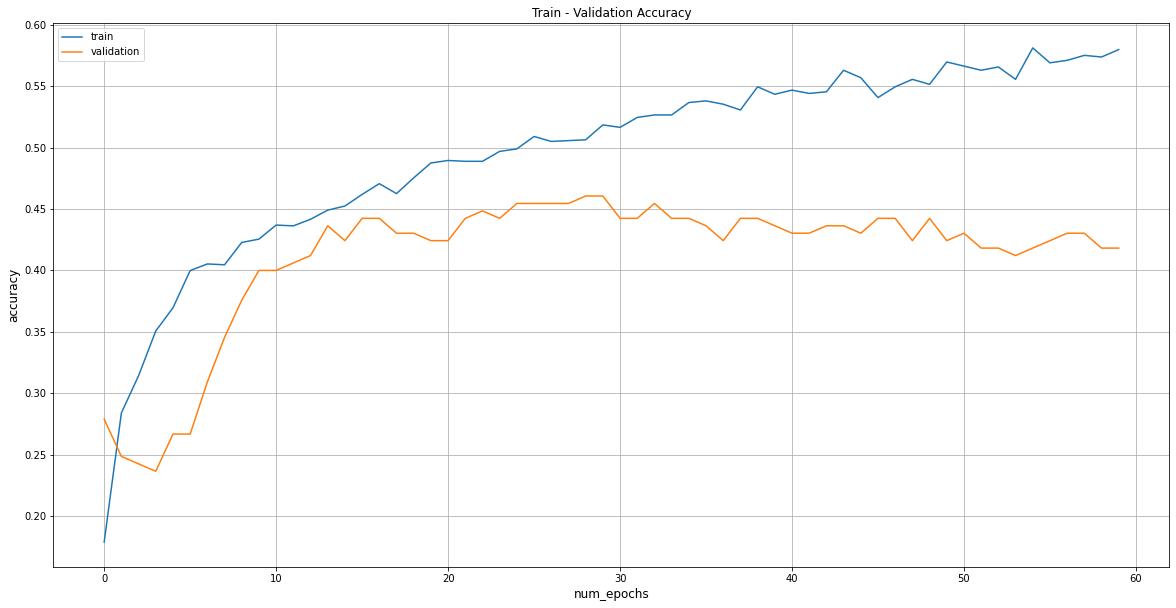

6/6 [==============================] - 4s 712ms/step - loss: 1.4837 - accuracy: 0.4863
Accuracy: 0.4863387942314148


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 8...
Epoch 1/60
47/47 [==============================] - 64s 1s/step - loss: 2.4054 - accuracy: 0.2299 - val_loss: 2.2198 - val_accuracy: 0.2970
Epoch 2/60
47/47 [==============================] - 46s 976ms/step - loss: 2.1460 - accuracy: 0.3425 - val_loss: 2.0685 - val_accuracy: 0.3030
Epoch 3/60
47/47 [==============================] - 44s 929ms/step - loss: 2.0297 - accuracy: 0.3527 - val_loss: 2.0083 - val_accuracy: 0.3030
Epoch 4/60
47/47 [==============================] - 43s 926ms/step - loss: 1.9672 - accuracy: 0.3688 - val_loss: 1.9669 - val_accuracy: 0.2970
Epoch 5/60
47/47 [==============================] - 43s 926ms/step - loss: 1.9259 - accuracy: 0.3978 - val_loss: 1.9455 - val_accuracy: 0.2788
Epoch 6/60
47/47 [==============================] - 45s 963ms/step - loss: 1.8870 - accuracy: 0.3911 - val_loss: 1.9184 - val_accuracy: 0.3091
Epoch 7/60
47/47 [==============================] - 46s 978ms/step - loss: 1.8483 - accuracy: 0.4032 - val_loss: 1.9008 -

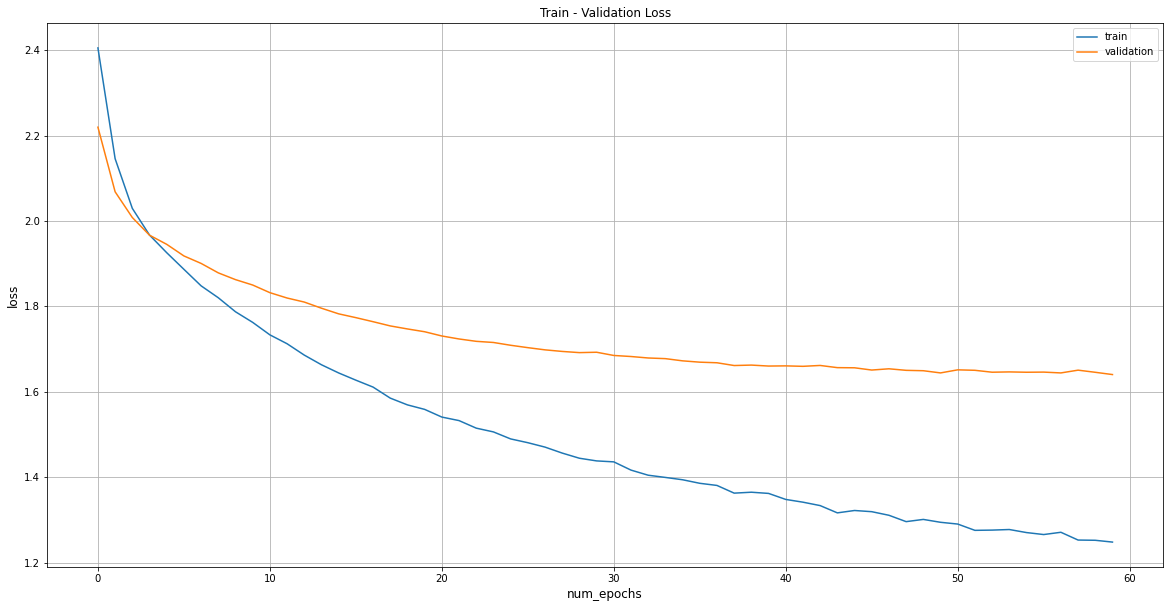

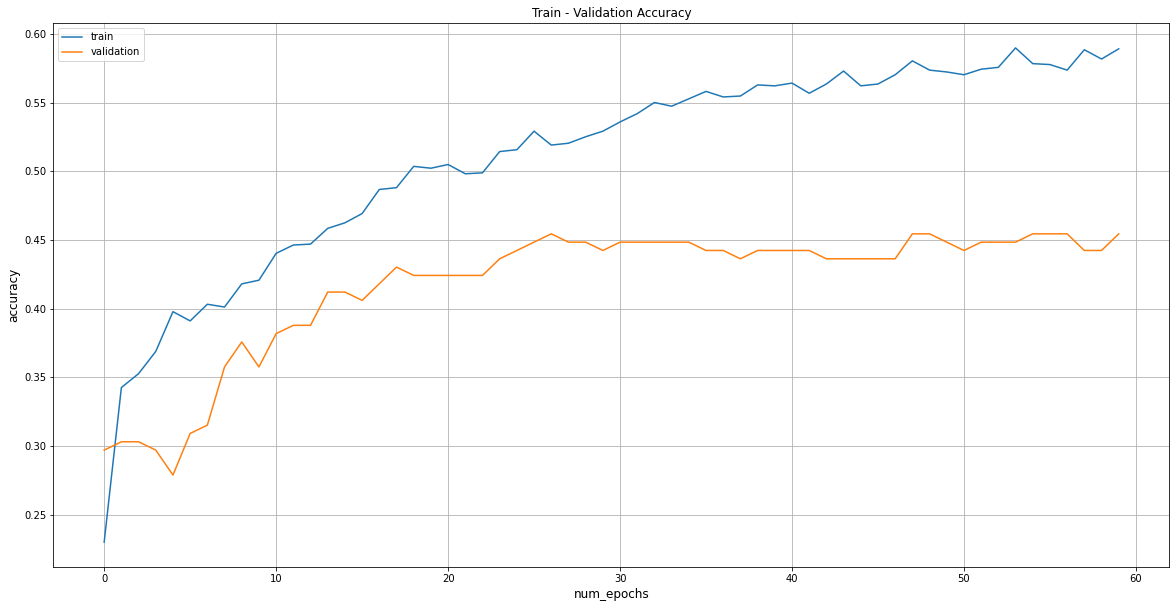

6/6 [==============================] - 4s 709ms/step - loss: 1.6083 - accuracy: 0.4809
Accuracy: 0.48087432980537415


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 9...
Epoch 1/60
47/47 [==============================] - 65s 1s/step - loss: 2.3848 - accuracy: 0.1989 - val_loss: 2.2321 - val_accuracy: 0.2303
Epoch 2/60
47/47 [==============================] - 44s 928ms/step - loss: 2.1518 - accuracy: 0.2980 - val_loss: 2.0858 - val_accuracy: 0.2182
Epoch 3/60
47/47 [==============================] - 44s 929ms/step - loss: 2.0411 - accuracy: 0.3243 - val_loss: 2.0264 - val_accuracy: 0.2182
Epoch 4/60
47/47 [==============================] - 46s 977ms/step - loss: 1.9848 - accuracy: 0.3574 - val_loss: 1.9881 - val_accuracy: 0.2485
Epoch 5/60
47/47 [==============================] - 46s 986ms/step - loss: 1.9339 - accuracy: 0.3729 - val_loss: 1.9592 - val_accuracy: 0.2667
Epoch 6/60
47/47 [==============================] - 45s 969ms/step - loss: 1.8945 - accuracy: 0.3904 - val_loss: 1.9337 - val_accuracy: 0.2788
Epoch 7/60
47/47 [==============================] - 46s 977ms/step - loss: 1.8607 - accuracy: 0.3972 - val_loss: 1.9099 -

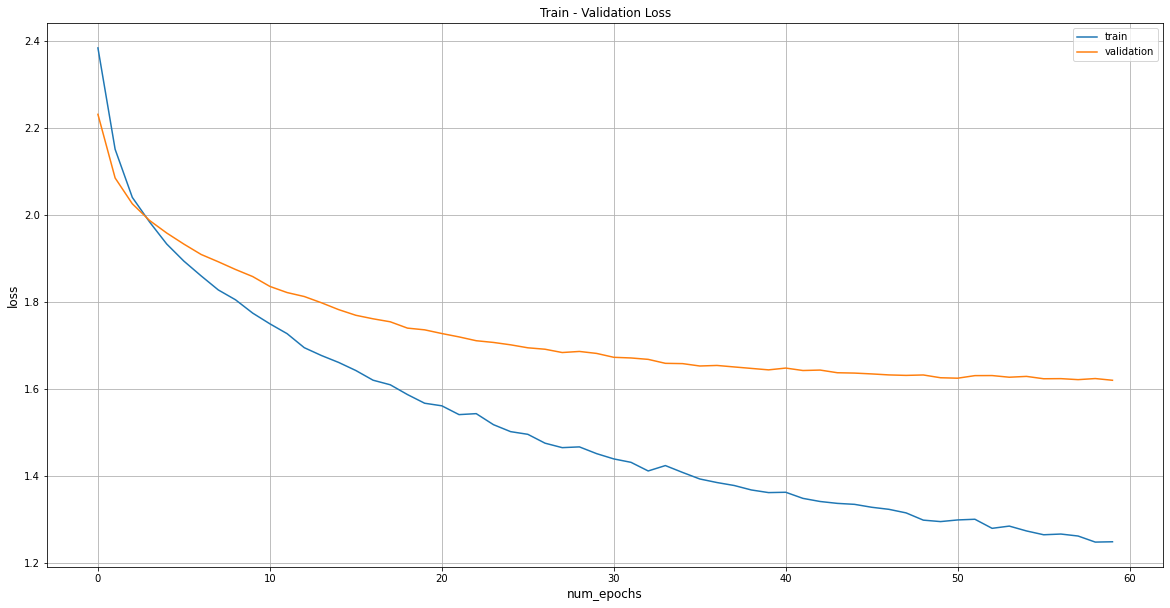

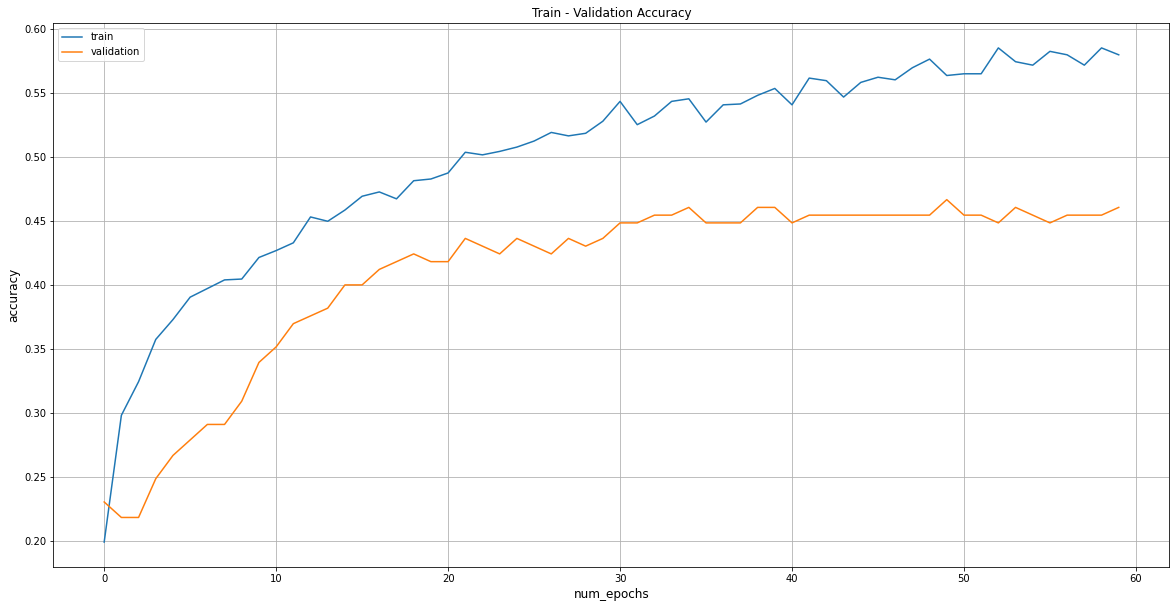

6/6 [==============================] - 4s 710ms/step - loss: 1.4553 - accuracy: 0.5137
Accuracy: 0.5136612057685852


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['classifier', 'bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting with Fold 10...
Epoch 1/60
47/47 [==============================] - 64s 1s/step - loss: 2.4247 - accuracy: 0.2306 - val_loss: 2.2466 - val_accuracy: 0.2788
Epoch 2/60
47/47 [==============================] - 45s 967ms/step - loss: 2.1576 - accuracy: 0.2852 - val_loss: 2.0799 - val_accuracy: 0.2970
Epoch 3/60
47/47 [==============================] - 45s 966ms/step - loss: 2.0426 - accuracy: 0.3082 - val_loss: 2.0105 - val_accuracy: 0.3030
Epoch 4/60
47/47 [==============================] - 45s 965ms/step - loss: 1.9761 - accuracy: 0.3540 - val_loss: 1.9681 - val_accuracy: 0.3152
Epoch 5/60
47/47 [==============================] - 44s 928ms/step - loss: 1.9336 - accuracy: 0.3682 - val_loss: 1.9415 - val_accuracy: 0.3091
Epoch 6/60
47/47 [==============================] - 46s 980ms/step - loss: 1.8909 - accuracy: 0.3783 - val_loss: 1.9130 - val_accuracy: 0.3515
Epoch 7/60
47/47 [==============================] - 44s 928ms/step - loss: 1.8597 - accuracy: 0.3864 - val_loss: 1.8891 

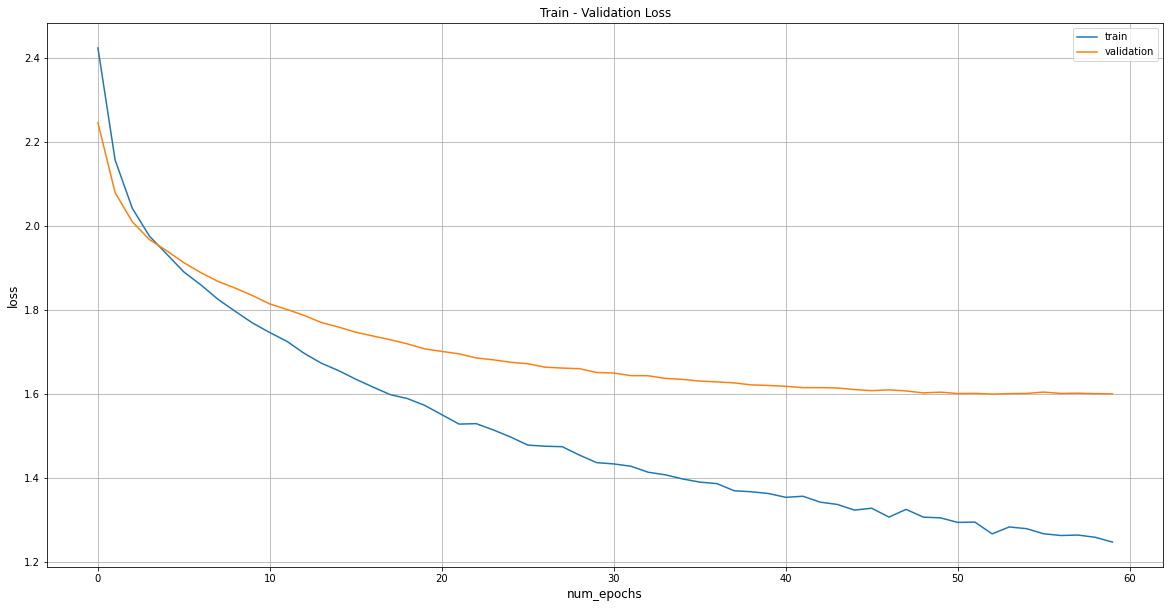

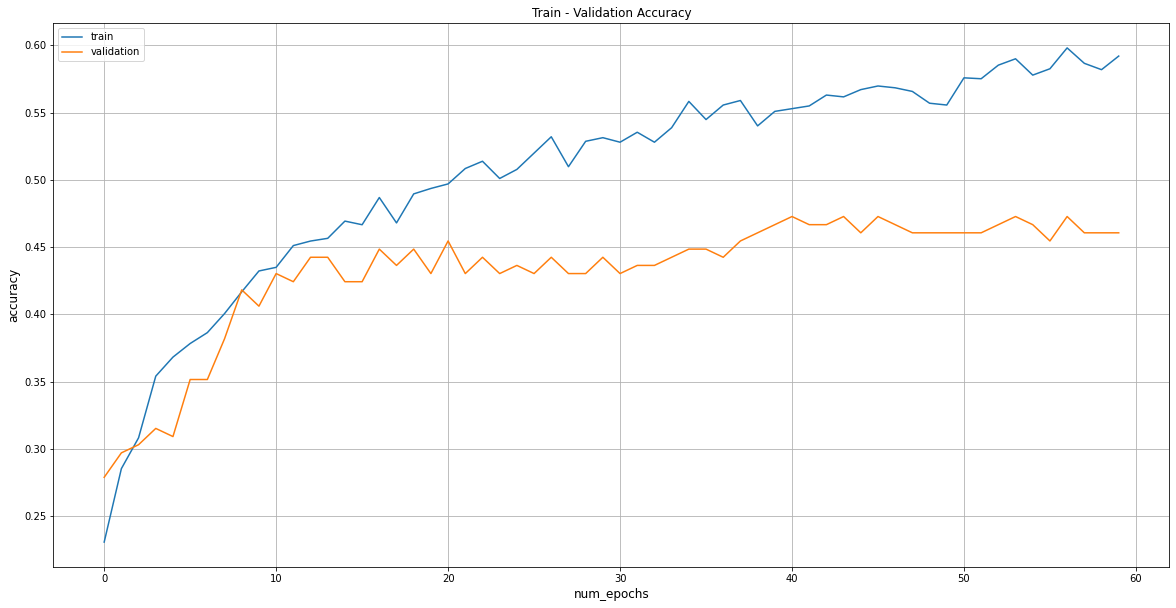

6/6 [==============================] - 4s 713ms/step - loss: 1.4994 - accuracy: 0.5137
Accuracy: 0.5136612057685852


accuracy    0.512842
dtype: float64

In [31]:
N_EPOCAS = 60
kfold = KFold(n_splits=10, shuffle=True)
acc = []
fold = 1
directory_checkpoint = "tfm/checkpoints/topic_tag_news/"
for train, test in kfold.split(dataset_labels.body_no_entities):
    
    fold_train_x = dataset_labels.body_no_entities.values[train]
    textos_train = tokenizer(fold_train_x.tolist(), padding="max_length", truncation=True, return_tensors="tf")
     
    fold_train_y = label[train]
            
    model_checkpoint_callback = ModelCheckpoint(
        filepath=f'{directory_checkpoint}/fold_{fold}',
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=15, mode='min')
    
    # Para cada Fold se entrena de nuevo
    model = TFBertForSequenceClassification.from_pretrained(checkpoint, num_labels=N_LABELS)
    model.layers[0].trainable=False
    model.layers[-1].activation=tf.keras.activations.softmax
    
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=0.0001),
        metrics=['accuracy']
    )

    print(f"Starting with Fold {fold}...")

    hist = model.fit(
        textos_train.data,
        fold_train_y,
        validation_split=0.1,
        epochs=N_EPOCAS,
        callbacks=[model_checkpoint_callback, early_stopping]
        )
    
    fold_test_x = dataset_labels.body_no_entities.values[test]
    textos_test = tokenizer(fold_test_x.tolist(), padding="max_length", truncation=True, return_tensors="tf")
    
    fold_test_y = label[test]

    fig = plt.figure(figsize=(20,10))
    plt.title("Train - Validation Loss")
    plt.plot(hist.history['loss'], label='train')
    plt.plot(hist.history['val_loss'], label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')
    plt.grid()
    plt.show()

    fig = plt.figure(figsize=(20,10))
    plt.title("Train - Validation Accuracy")
    plt.plot(hist.history['accuracy'], label='train')
    plt.plot(hist.history['val_accuracy'], label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('accuracy', fontsize=12)
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    model.load_weights(f'{directory_checkpoint}/fold_{fold}')
    i_acc  = model.evaluate(textos_test.data, fold_test_y)
    print("Accuracy:", i_acc[1])
    acc.append(i_acc[1])
    
    fold += 1
result = pd.DataFrame({'accuracy':acc})
result.mean()

In [32]:
result

,accuracy
0,0.500000
1,0.469945
2,0.546448
3,0.502732
4,0.551913
5,0.562842
6,0.486339
7,0.480874
8,0.513661
9,0.513661


In [33]:
result.mean()

accuracy    0.512842
dtype: float64